# ch 9. dimension reduction

## 차원 축소
word2vec 모델을 이용해서 단어를 n차원 벡터로 표현할 수 있었습니다. 이를 이용해 단어 벡터끼리 더하거나 빼고, 유사한 단어를 찾을 수 있었습니다. 그런데 이를 좌표 평면에 시각화 하고 싶다면 어떻게 할 수 있을까요? 바로 n차원 데이터를 2차원이나 3차원으로 차원을 축소한 다음, 시각화를 할 수 있습니다. 이 때 사용되는 기법이 차원 축소입니다.

차원 축소는 데이터의 성질은 보존하면서 차원의 수를 줄여주는 기법으로, PCA(주성분 분석)과 t-sne가 대표적입니다.

## PCA(주성분 분석) principal component analysis

### 주성분 분석의 직관적 이해
주성분 분석을 직관적으로 이해하면, 데이터의 분포를 가장 잘 설명하는 새로운 성분을 찾아서, 그 성분 위에 각 데이터 포인트들을 사상시켜서 차원을 줄이는 기법입니다. 예시를 통해서 알아보겠습니다. 

점으로 표기할 수 있는 2차원 데이터가 좌표 평면 위에 시각화 되어있다고 가정하겠습니다. 우리가 원하는 건 데이터의 분포는 유지하면서, 2차원 데이터를 1차원으로 줄이는 것입니다. 어떻게 할 수 있을까요?

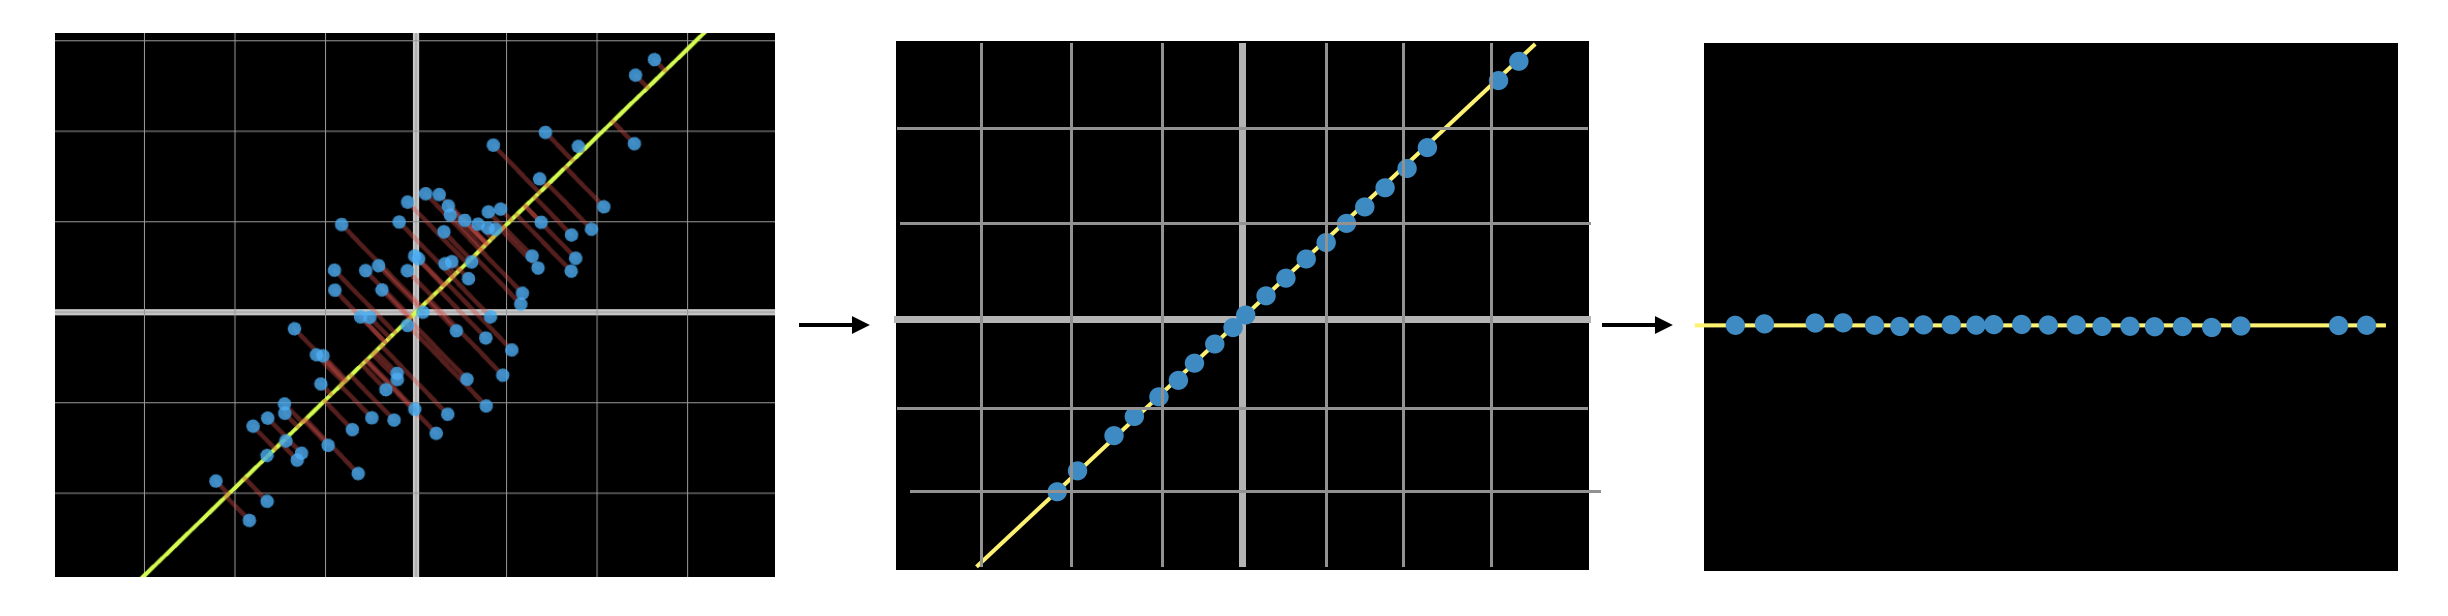

먼저 데이터의 변동을 가장 잘 설명하는 벡터를 찾습니다. 이를 주성분이라고 표현합니다. 이제 2차원 데이터 샘플들을 이 주성분에 수직으로 이동시킵니다. 이를 정사영 시킨다고 표현합니다. 정사영 시키면 2차원 점들이 주성분 위의 점들로 표현할 수 있습니다. 동시에 데이터의 분포를 최대한 유지시킬 수 있습니다.

3차원 데이터를 2차원으로 줄이는 것도 시각적으로 표현하면 아래와 같습니다. 데이터의 변동을 가장 잘 설명하는 주성분 2개를 찾고, 주성분들이 만드는 초평면 위에 데이터들을 정사영 시키면 3차원 데이터들을 2차원 평면 위에 점으로 표현할 수 있습니다.

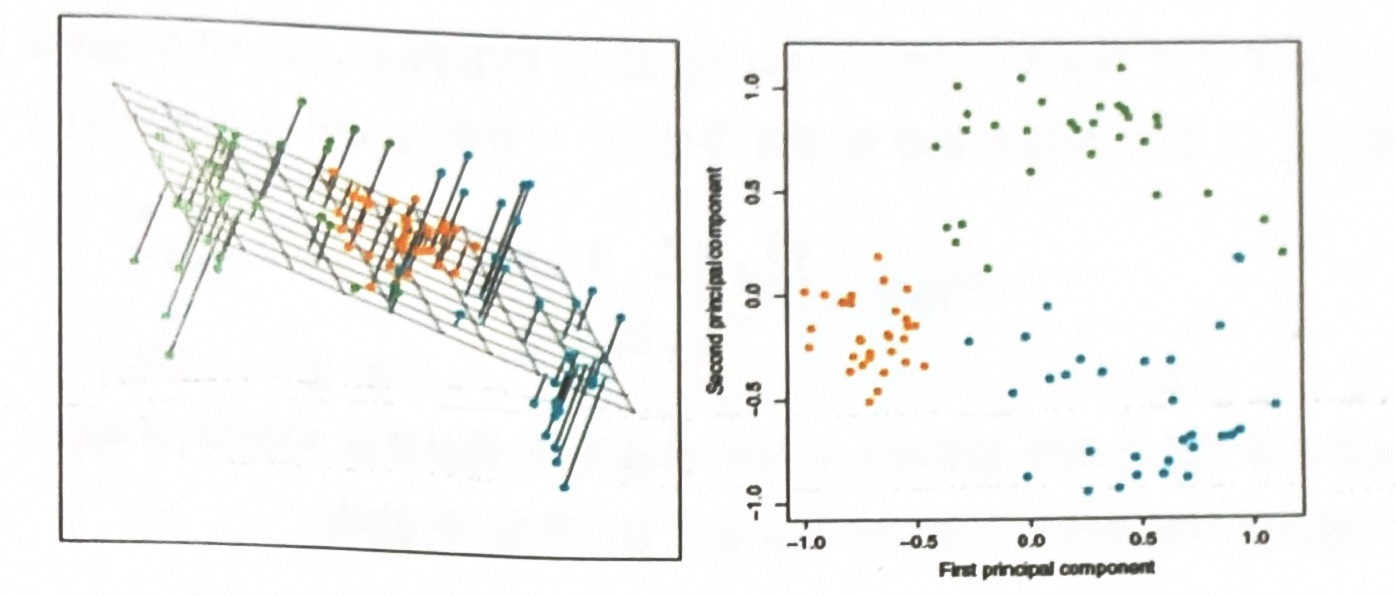
사상, projection

차원이 더 늘어나도 상관없습니다. 주어진 데이터의 변동을 가장 잘 설명하는 주성분 n개를 찾고, 기존의 데이터들을 n개의 주성분 위에 사영시키면 데이터의 분포를 최대한 유지하면서 데이터의 차원을 줄여줄 수 있습니다. 이러한 기법을 주성분 분석이라고 표현합니다.

정리해보면, 주성분 분석이란 데이터의 변동을 가장 잘 설명할 수 있는 주성분들을 찾고, 데이터들을 각 주성분 위의 점들로 표현하여 주성분의 개수만큼의 차원으로 축소하는 기법입니다.

### 주성분 분석의 계산

선형 대수학을 이용해서 주성분을 찾으려면 다음과 같은 과정을 거쳐야 합니다. 

1. 데이터 표준화
2. 공분산 행렬 계산
3. 공분산 행렬 고유값 분해
4. 주성분 선택
5. 데이터 변환

계산 과정이 꽤나 복잡하고, 그 과정에서 선형대수학 지식이 많이 필요하여 자세한 계산 과정은 생략하겠습니다. 궁금하신 분들은 아래 자료를 참고하시면 도움이 됩니다.

https://angeloyeo.github.io/2019/07/27/PCA.html

## PCA를 사용한 임베딩 벡터 시각화

scikit learn에 내장된 PCA 클래스를 이용하여 PCA를 사용해보겠습니다. 미리 학습된 word2vec 모델을 읽어와 야구 선수들의 임베딩 벡터를 2차원으로 축소한 다음, 시각화 해보겠습니다. scikit learn을 이용하면 놀라우리만치 쉽습니다.

### 선수 이름 데이터 셋 준비

In [2]:
import csv
from collections import defaultdict

players = []
players_by_team = defaultdict(list) 
players_by_position = defaultdict(list) 
with open("./data/baseball_players.csv", encoding="utf-8") as fr:
    reader = csv.reader(fr)
    result = next(reader)
    for row in reader:
        team, pitchers, catchers, infielders, outfielders = row
        pitchers = pitchers.split("\n")
        catchers = catchers.split("\n")
        infielders = infielders.split("\n")
        outfielders = outfielders.split("\n")
        players.extend(pitchers + catchers + infielders + outfielders)
        players_by_team[team] = pitchers + catchers + infielders + outfielders
        players_by_position["투수"].extend(pitchers)
        players_by_position["포수"].extend(catchers)
        players_by_position["내야수"].extend(infielders)
        players_by_position["외야수"].extend(outfielders)

In [3]:
player_team_dict = {}
for team in players_by_team:
    for player in players_by_team[team]:
        player_team_dict[player] = team 

In [4]:
player_position_dict = {}
for position in players_by_position:
    for player in players_by_position[position]:
        player_position_dict[player] = position 

In [8]:
#player_team_dict

### word2vec 모델 불러오기

In [9]:
from gensim.models import Word2Vec

model = Word2Vec.load("./data/baseball_word2vec.model")

### word2vec 모델이 학습한 선수 이름만 필터링

In [10]:
total_players = set(players)

In [11]:
vocabs = set(model.wv.index_to_key)

In [13]:
filtered_players = total_players.intersection(vocabs)

In [15]:
print("before filtering", len(total_players))
print("after filtering", len(filtered_players))

before filtering 275
after filtering 207


### 전체 선수 임베딩 벡터 시각화

전체 선수들의 임베딩 벡터를 2차원 평면에 시각화 해보겠습니다.

In [17]:
import numpy as np

players_word_vectors = np.array([model.wv[player] for player in filtered_players])

In [18]:
players_word_vectors  

array([[-0.7536465 ,  0.25220832, -1.0832427 , ..., -0.31350616,
        -1.0377684 ,  0.14624222],
       [-0.8062969 ,  0.29883835, -0.4281822 , ..., -0.39963233,
        -0.20158061,  0.9498413 ],
       [-0.40355116,  0.49385878,  0.15006042, ...,  0.12487844,
        -0.69409394,  0.94652146],
       ...,
       [-0.02687739, -0.8041723 , -0.6567074 , ..., -0.7354416 ,
        -0.6827033 ,  0.6120224 ],
       [-0.5955181 ,  0.11149903,  0.3622319 , ...,  0.09629896,
        -0.4094071 , -0.2544939 ],
       [-0.16013928, -0.45331365,  0.17961855, ..., -0.45727766,
        -0.09482226,  0.6056048 ]], dtype=float32)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)   # 축소하고자 하는 차원 = 주성분의 수
pca_reduced_vectors = pca.fit_transform(players_word_vectors)

In [20]:
pca_reduced_vectors

array([[ 1.1906253 ,  0.87639004],
       [ 0.74853134,  0.9823211 ],
       [-0.9496153 , -0.6735899 ],
       [-0.8335308 ,  0.18263482],
       [-0.8308687 , -0.7532451 ],
       [ 0.8421384 , -0.23165773],
       [ 0.9996309 , -0.07120272],
       [ 0.768457  ,  0.79878634],
       [-0.55546665, -0.10346401],
       [-0.5494029 , -0.92771256],
       [-0.543803  ,  0.3146497 ],
       [ 0.77274877,  0.27258053],
       [-0.12100803,  0.45157412],
       [-0.5737238 ,  1.2804941 ],
       [ 0.7145329 , -0.9651596 ],
       [ 1.2647487 , -0.19119994],
       [ 0.74795216, -0.52554154],
       [-0.89618266, -0.6879496 ],
       [ 0.9852272 ,  0.45650366],
       [ 0.9573469 ,  0.19098987],
       [ 0.8910238 , -0.23048095],
       [ 0.5109834 , -0.5077786 ],
       [-1.035333  , -0.1993377 ],
       [-1.1229239 , -0.38824025],
       [-0.67384577, -0.84995663],
       [-0.6721776 ,  1.1303232 ],
       [ 1.0088048 ,  0.7648621 ],
       [ 0.5926025 , -1.0264393 ],
       [-0.9353819 ,

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)   # 축소하고자 하는 차원 = 주성분의 수
pca_reduced_vectors = pca.fit_transform(players_word_vectors)

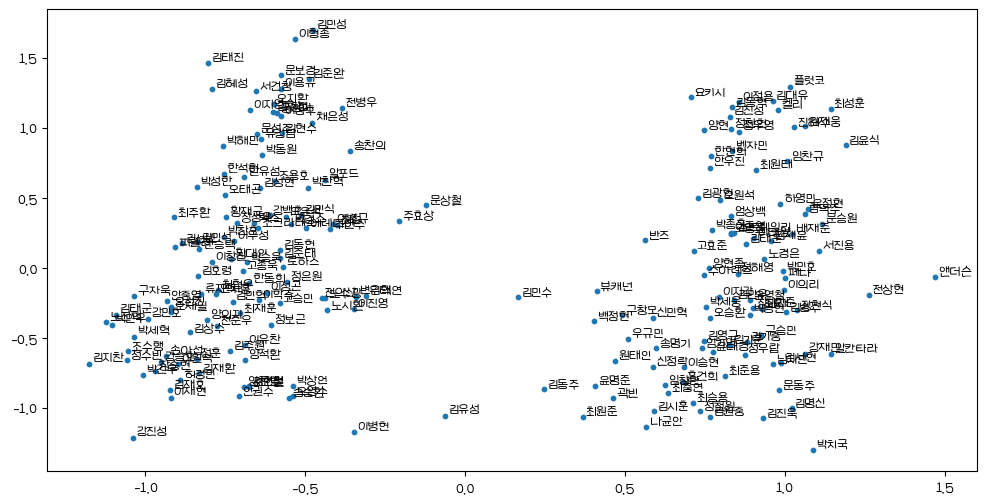

In [35]:
from matplotlib import pyplot as plt

plt.rc("font", family="LeeSeoyun")
#plt.rcParams['font.family'] ='Malgun Gothic'
#plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(12,6))
plt.scatter(pca_reduced_vectors[:,0], pca_reduced_vectors[:,1], s =10)
for i,player_name in enumerate(filtered_players):
    x, y = pca_reduced_vectors[i]
    plt.text(x + 0.01, y+0.01, player_name)

### 팀별 임베딩 벡터 시각화

In [37]:
players_index_dict = {player: i for i, player in enumerate(filtered_players)}

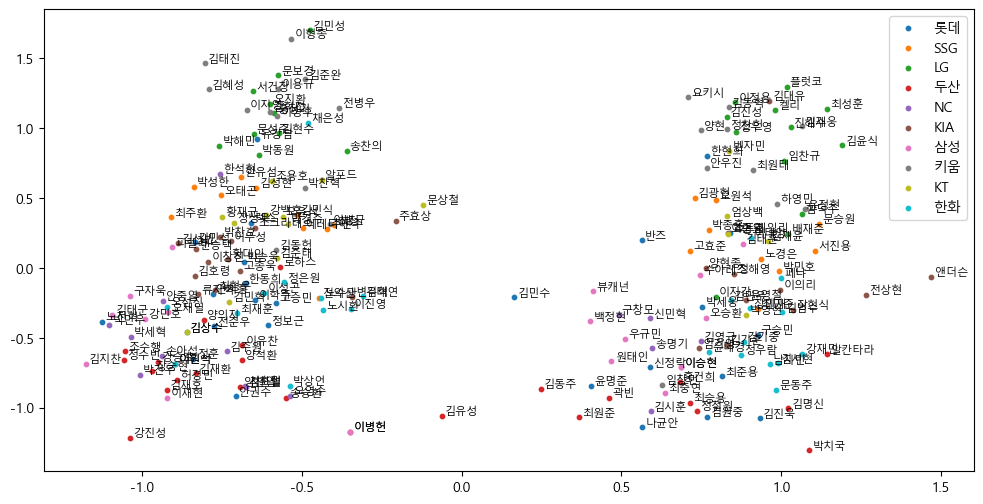

In [41]:
plt.rc("font", family="Malgun Gothic")
plt.figure(figsize=(12,6))

for team in players_by_team.keys():
    player_names = [x for x in players_by_team[team] if x in filtered_players]
    player_indices = [players_index_dict[x] for x in player_names]
    players_vector = pca_reduced_vectors[player_indices]
    plt.scatter(players_vector[:,0], players_vector[:,1], s =10, label=team)
    for i,player_name in enumerate(player_names):
        x,y = players_vector[i]
        plt.text(x + 0.01, y + 0.01, player_name, fontsize=8)
plt.legend()

### 포지션 별 임베딩 벡터 시각화

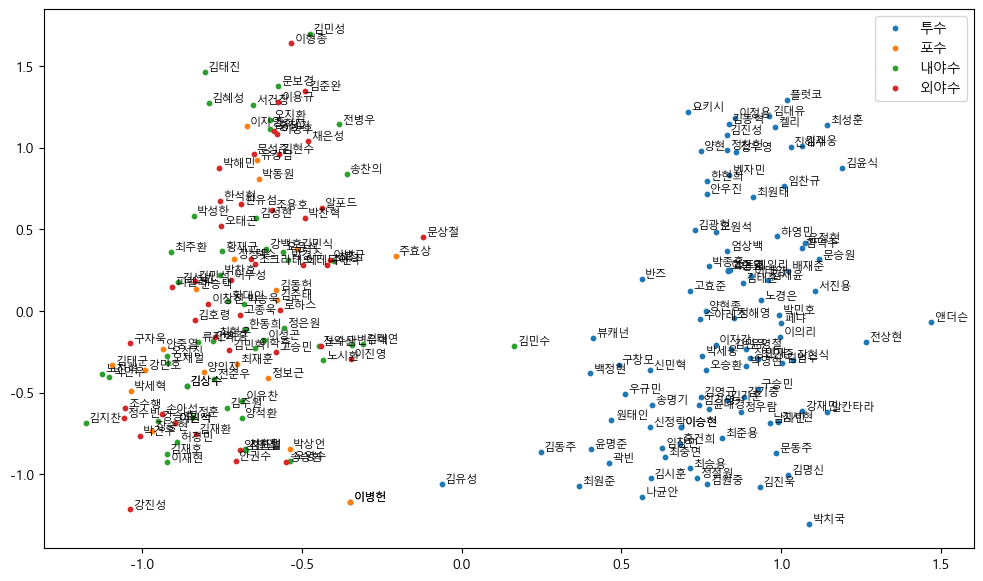

In [44]:
plt.rc("font", family="Malgun Gothic")
plt.figure(figsize=(12,7))

for position in players_by_position.keys():
    player_names = [x for x in players_by_position[position] if x in filtered_players]
    player_indices = [players_index_dict[x] for x in player_names]
    players_vector = pca_reduced_vectors[player_indices]
    plt.scatter(players_vector[:,0], players_vector[:,1], s=10, label=position)
    for i,player_name in enumerate(player_names):
        x,y = players_vector[i]
        plt.text(x + 0.01, y + 0.01, player_name, fontsize=8)
plt.legend()

## t-sne (t-distributed stochastic neighbor embedding)

### t-sne 개념
t-sne 는 차원을 축소하는 또 다른 기법입니다. 앞서 PCA는 데이터의 변동을 가장 잘 설명하는 주성분을 찾아서, 주성분에 데이터들을 선형 사상했습니다. 그런데 이렇게 하면 원래의 차원에서 군집을 이루고 있는 데이터들이 축소된 차원에서는 뭉개지는 현상이 발생합니다.

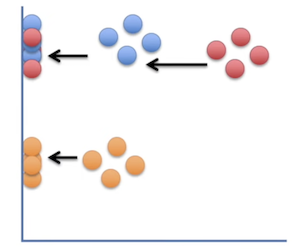

2차원 상에서는 파란점과 빨간점이 군집을 이루고 있었는데, 축소된 차원에서는 이 둘이 구분되지 않습니다. 이러한 군집 정보를 살리면서 차원을 축소하자는 아이디어가 t-sne 입니다.

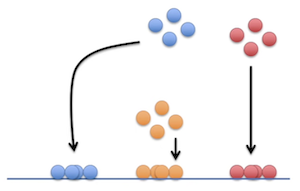

### t-sne 학습 과정 

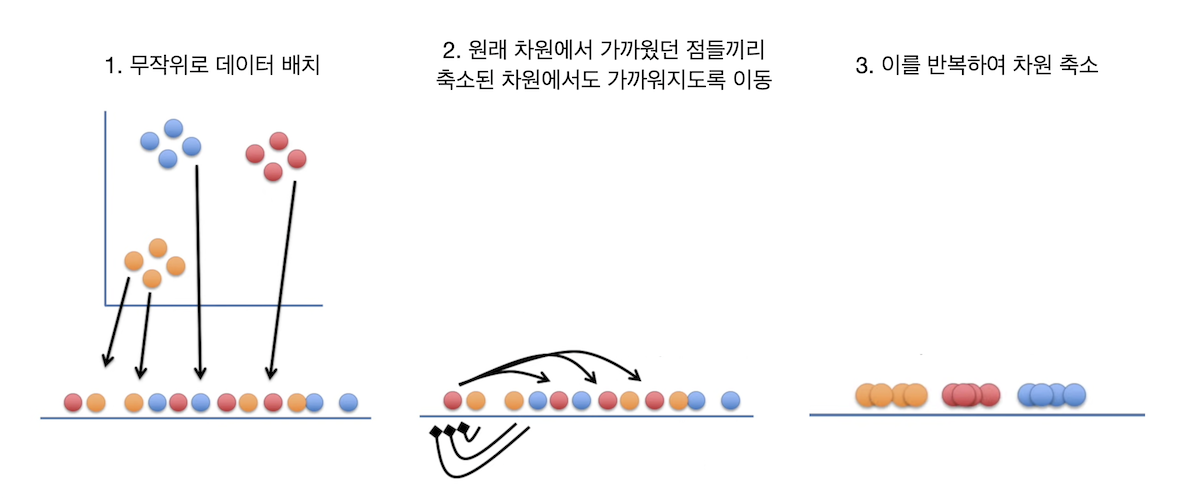

t-sne는 먼저 데이터 샘플들을 무작위로 축소된 차원에 배치합니다. 그 다음, 원래의 차원에서 서로 가까웠던 샘플들 끼리는 가깝게, 멀었던 샘플들은 서로 멀게 데이터 샘플들을 이동시킵니다. 이를 반복하여 벡터의 차원을 축소시키는 것이 t-sne입니다.

t-sne에 대해 더 궁금하신 분들은 아래 강의를 참고해주세요.  
https://www.youtube.com/watch?v=NEaUSP4YerM

### t-sne와 pca의 관계

t-sne가 처음 임베딩 벡터의 차원을 줄일 때, 무작위로 데이터를 배치할 수도 있지만, PCA를 이용하여 배치하기도 합니다. sklearn에 내장된 t-sne는 PCA를 이용하여 차원을 먼저 축소한 다음, 원래의 차원에서 거리가 가까웠던 데이터 샘플들끼리 모이도록 데이터 샘플들을 재배치합니다. 즉, t-sne는 PCA를 보완하는 모델입니다. 

일반적으로 딥러닝 모델을 통해서 얻은 임베딩 벡터의 차원을 축소하여 시각화 할 때는 t-sne 기법을 사용하고, 이를 t-sne graph라고 부릅니다.

## t-sne를 이용한 임베딩 벡터 시각화

sklearn을 이용하여 t-sne로 차원 축소를 진행해보겠습니다. PCA와 거의 사용 방법이 동일합니다. 

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_reduced_vectors = tsne.fit_transform(players_word_vectors)

### 전체 선수 임베딩 시각화

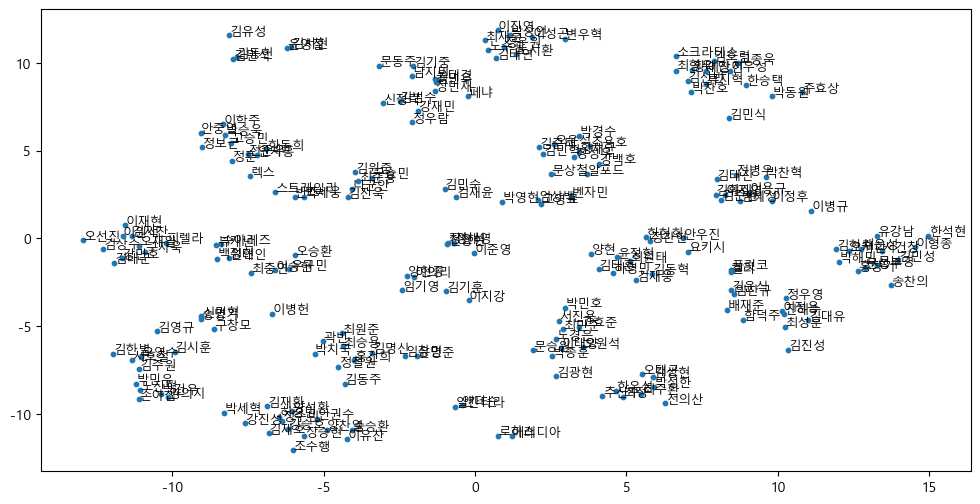

In [49]:
plt.rc("font", family="Malgun Gothic")

plt.figure(figsize=(12,6))
plt.scatter(tsne_reduced_vectors[:,0], tsne_reduced_vectors[:,1], s =10)
for i,player_name in enumerate(filtered_players):
    x, y = tsne_reduced_vectors[i]
    plt.text(x + 0.01, y+0.01, player_name, fontsize=9)

### 팀별 선수 임베딩 시각화

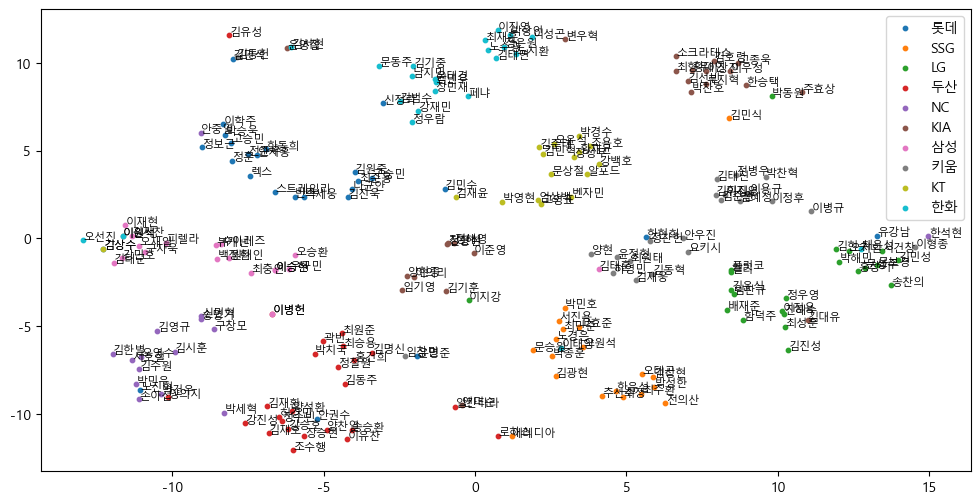

In [50]:
plt.rc("font", family="Malgun Gothic")
plt.figure(figsize=(12,6))

for team in players_by_team.keys():
    player_names = [x for x in players_by_team[team] if x in filtered_players]
    player_indices = [players_index_dict[x] for x in player_names]
    players_vector = tsne_reduced_vectors[player_indices]
    plt.scatter(players_vector[:,0], players_vector[:,1], s =10, label=team)
    for i,player_name in enumerate(player_names):
        x,y = players_vector[i]
        plt.text(x + 0.01, y + 0.01, player_name, fontsize=8)
plt.legend()

### 포지션 별 선수 임베딩 시각화

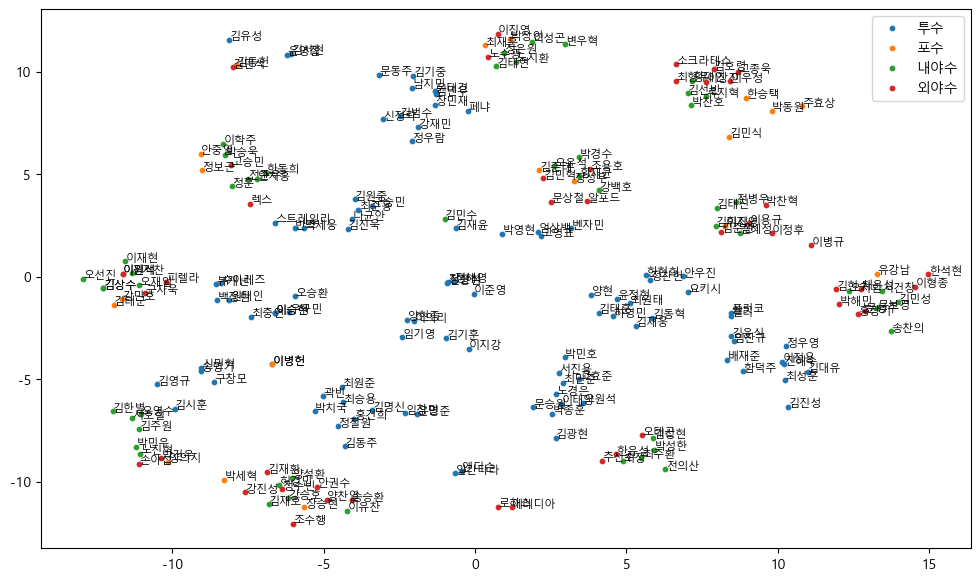

In [51]:
plt.rc("font", family="Malgun Gothic")
plt.figure(figsize=(12,7))

for position in players_by_position.keys():
    player_names = [x for x in players_by_position[position] if x in filtered_players]
    player_indices = [players_index_dict[x] for x in player_names]
    players_vector = tsne_reduced_vectors[player_indices]
    plt.scatter(players_vector[:,0], players_vector[:,1], s=10, label=position)
    for i,player_name in enumerate(player_names):
        x,y = players_vector[i]
        plt.text(x + 0.01, y + 0.01, player_name, fontsize=8)
plt.legend()

## 정리

이번 챕터에서는 벡터의 차원 축소에 대해서 알아보았습니다. 그리고 PCA와 t-sne의 기본 개념을 익히고, 실제 word2vec 모델을 통해 얻은 임베딩 벡터의 차원을 축소하여 시각화 해보았습니다.

PCA의 경우 벡터의 차원을 줄여야하는 상황에 보편적으로 많이 사용되고, t-sne는 시각화를 하는 상황에 주로 사용됩니다. 이 점을 잘 기억해서 적재 적소에 활용할 수 있으면 좋겠습니다.